In [2]:
import optuna
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def save_config(config, save_path):
    with open(save_path, "w") as f:
        json.dump(config, f)

def save_best_results(best_trial, model_name, cls_type, n_edges="default", dir="./best"):
    
    config = load_config("./tune_cls.json")
    
    for key, value in best_trial.params.items():
        config[key] = value

    file_name = f"{model_name}_{n_edges}"

    config["net_type"] = model_name
    config["cls_type"]= cls_type
    
    if model_name=="MLP":
        file_name = "MLP"

    config["epochs"] = round(best_trial.user_attrs["avg_epoch"])

    if n_edges!="default":
        config["n_edges"] = n_edges

    keys_to_remove = []
    for key, value in config.items():
        if isinstance(value, list):
            keys_to_remove.append(key)

    for key in keys_to_remove:
        del config[key]

    save_config(config, f"./{dir}/{file_name}.json")

def study_results(study_name, dir="./", sort_by ="f1", verbose=False, target_fn=lambda t: t.values[0]):
    path = os.path.join(dir, f"{study_name}_study.db")
    # print(path)

    # study = optuna.load_study(study_name=study_name, storage=f"sqlite:///../baseline_results/mogcn_latent/{study_name}_study.db")    
    study = optuna.load_study(study_name=study_name, storage=f"sqlite://{path}")    

    # pruned_trials = [
    #     t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED
    # ]
    # complete_trials = [
    #     t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
    # ]

    best_trials = sorted(study.best_trials, key=lambda d: d.values[0] if sort_by =="f1" else d.values[1], reverse=True)

    if verbose:
        i = 0
        for trial in best_trials:
            print("Trial number ",i)
            print("\tBest mean values: ", trial.values)
            print("\tCustom metrics: ", trial.user_attrs)

            print("\tParams: ")
            for key, value in trial.params.items():
                print(f"\t\t{key}: {value}")
            i+=1
    # target=lambda x: x[1]
    # fig = optuna.visualization.plot_param_importances(study)
    # fig.show()
    
    # fig = optuna.visualization.plot_optimization_history(study, target=target_fn)
    # fig.show()
            

    return best_trials

def update_df_trials(df, def_best, trials, model, n_edges, cls_type, finetuned_by):
    df["f1"].extend([trial.values[0] for trial in trials])
    df["chi-square"].extend([trial.values[1] for trial in trials])
    df["model"].extend([model]*len(trials))
    df["n_edges"].extend([n_edges]*len(trials))
    df["cls_type"].extend([cls_type]*len(trials))
    df["finetuned_by"].extend([finetuned_by]*len(trials))

    best_trial = trials[0]
    def_best["f1"].append(best_trial.values[0])
    def_best["chi-square"].append(best_trial.values[1])
    def_best["model"].append(model)
    def_best["n_edges"].append(n_edges)
    def_best["cls_type"].append(cls_type)
    def_best["finetuned_by"].append(finetuned_by)


# def update_df_best_trials(df, best_trial, model, n_edges, cls_type, finetuned_by):
#     df["f1"].append(best_trial.values[0])
#     df["chi-square"].append(best_trial.values[1])
#     df["model"].append(model)
#     df["n_edges"].append(n_edges)
#     df["cls_type"].append(cls_type)
#     df["finetuned_by"].append(finetuned_by)
#     return df

df_best = {
    "model":[],
    "n_edges":[],
    "cls_type":[],
    "finetuned_by":[],
    "f1":[],
    "chi-square":[]
}


df_trials = {
    "model":[],
    "n_edges":[],
    "cls_type":[],
    "finetuned_by":[],
    "f1":[],
    "chi-square":[]
}


#### MLP

In [3]:
trials = study_results("MLP","/with_MLP", sort_by="f1", verbose=False)
update_df_trials(df_trials,df_best, trials, "MLP", n_edges=None, cls_type="MLP", finetuned_by="f1")
save_best_results(trials[0],"MLP","MLP",dir="with_MLP/best_f1")


trials = study_results("MLP","/with_MLP", sort_by="chi_squared", verbose=False)
update_df_trials(df_trials,df_best, trials, "MLP", n_edges=None, cls_type="MLP", finetuned_by="chi_squared")
save_best_results(trials[0],"MLP","MLP",dir="with_MLP/best_chi")

#### GNN

In [4]:
n_edges = [0, "default", 1000, 2500, 5000]
gnn_models = ["GCN", "GAT", "GATv2"]
dirs = ["/with_MLP", "/without_MLP"]

for dir in dirs:
    for model in gnn_models:
        for n in n_edges:
            trials = study_results(f"{model}_{n}", dir, sort_by="f1", verbose=False)
            update_df_trials(
                df_trials,
                df_best,
                trials,
                model,
                n_edges=n,
                cls_type="MLP" if dir == "/with_MLP" else model,
                finetuned_by="f1",
            )
            save_best_results(trials[0], model, "MLP" if dir == "/with_MLP" else model, n, dir=f"{dir}/best_f1")

            trials = study_results(
                f"{model}_{n}", dir, sort_by="chi", verbose=False
            )
            update_df_trials(
                df_trials,
                df_best,
                trials,
                model,
                n_edges=n,
                cls_type="MLP" if dir == "/with_MLP" else model,
                finetuned_by="chi_squared",
            )
            save_best_results(trials[0], model, "MLP" if dir == "/with_MLP" else model, n, dir=f"{dir}/best_chi")

## ALL trials

In [119]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(df_trials)
df["n_edges"] = df["n_edges"].fillna(0)
df

,model,n_edges,cls_type,finetuned_by,f1,chi-square
0,MLP,0,MLP,f1,0.939148,9.478961
1,MLP,0,MLP,f1,0.937452,10.826527
2,MLP,0,MLP,f1,0.932804,10.956825
3,MLP,0,MLP,f1,0.930462,11.698704
4,MLP,0,MLP,f1,0.929439,12.930424
...,...,...,...,...,...,...
453,GATv2,5000,GATv2,chi_squared,0.826629,21.782558
454,GATv2,5000,GATv2,chi_squared,0.833799,20.249462
455,GATv2,5000,GATv2,chi_squared,0.856711,18.976213
456,GATv2,5000,GATv2,chi_squared,0.874481,17.706722


#### F1 over Chi2

<Axes: xlabel='chi-square', ylabel='f1'>

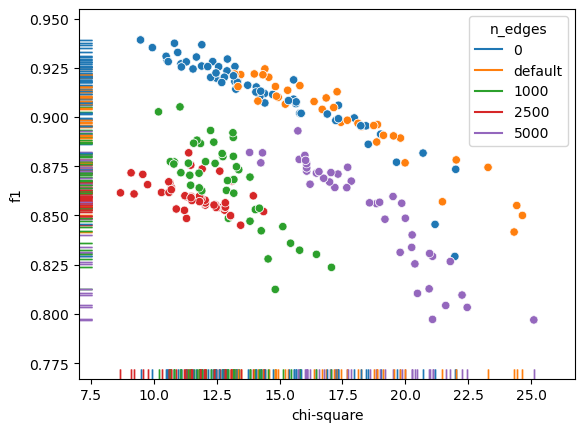

In [156]:
sns.scatterplot(data=df, y="f1", x="chi-square",hue="n_edges")
sns.rugplot(data=df, y="f1", x="chi-square",hue="n_edges")

/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


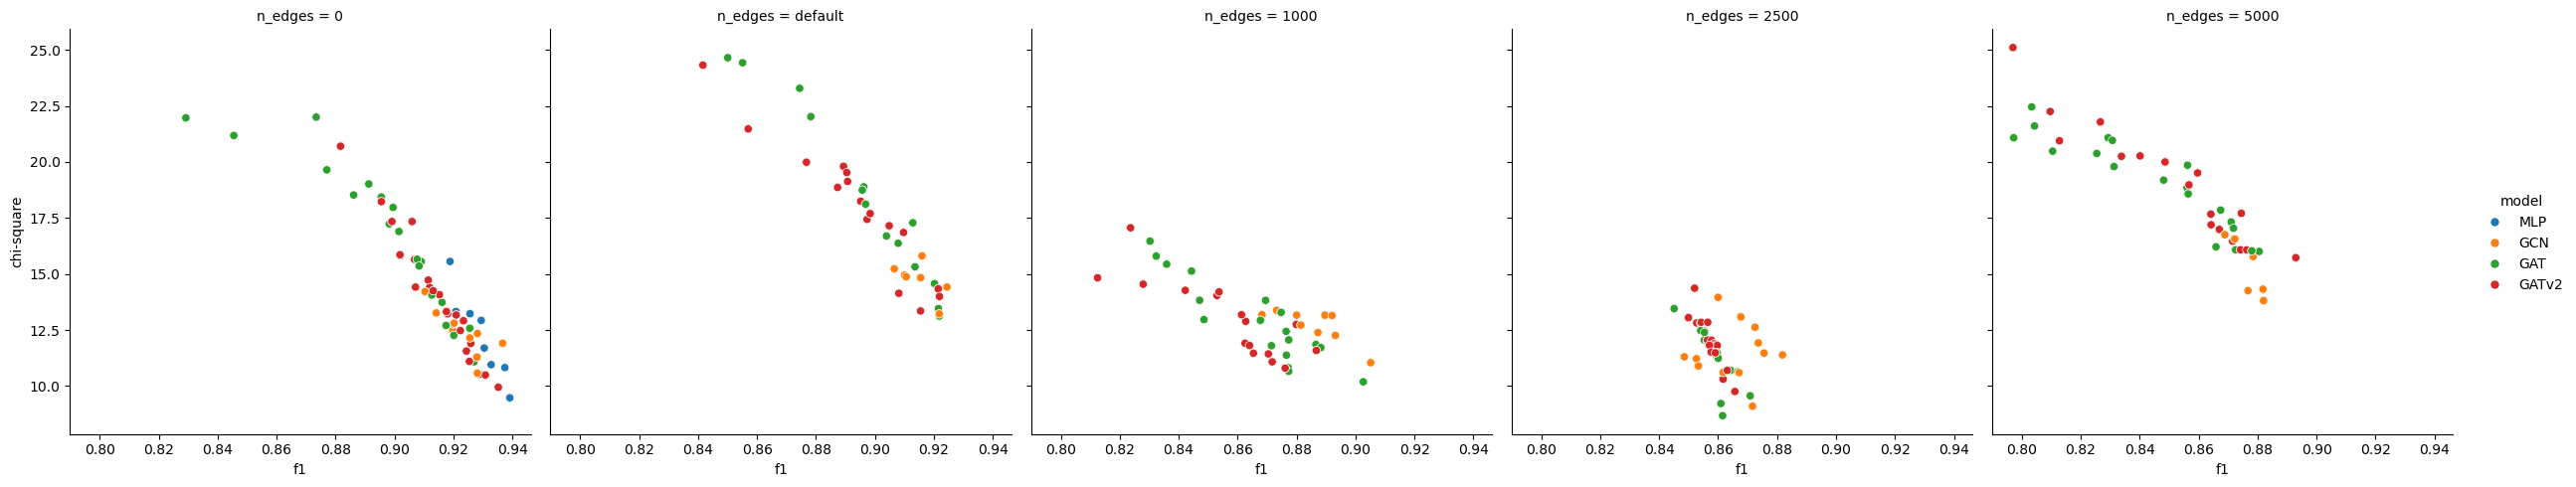

In [93]:
sns.relplot(data=df, x="f1", y="chi-square", hue="model", col="n_edges")

/home/davide/miniconda3/envs/omics/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


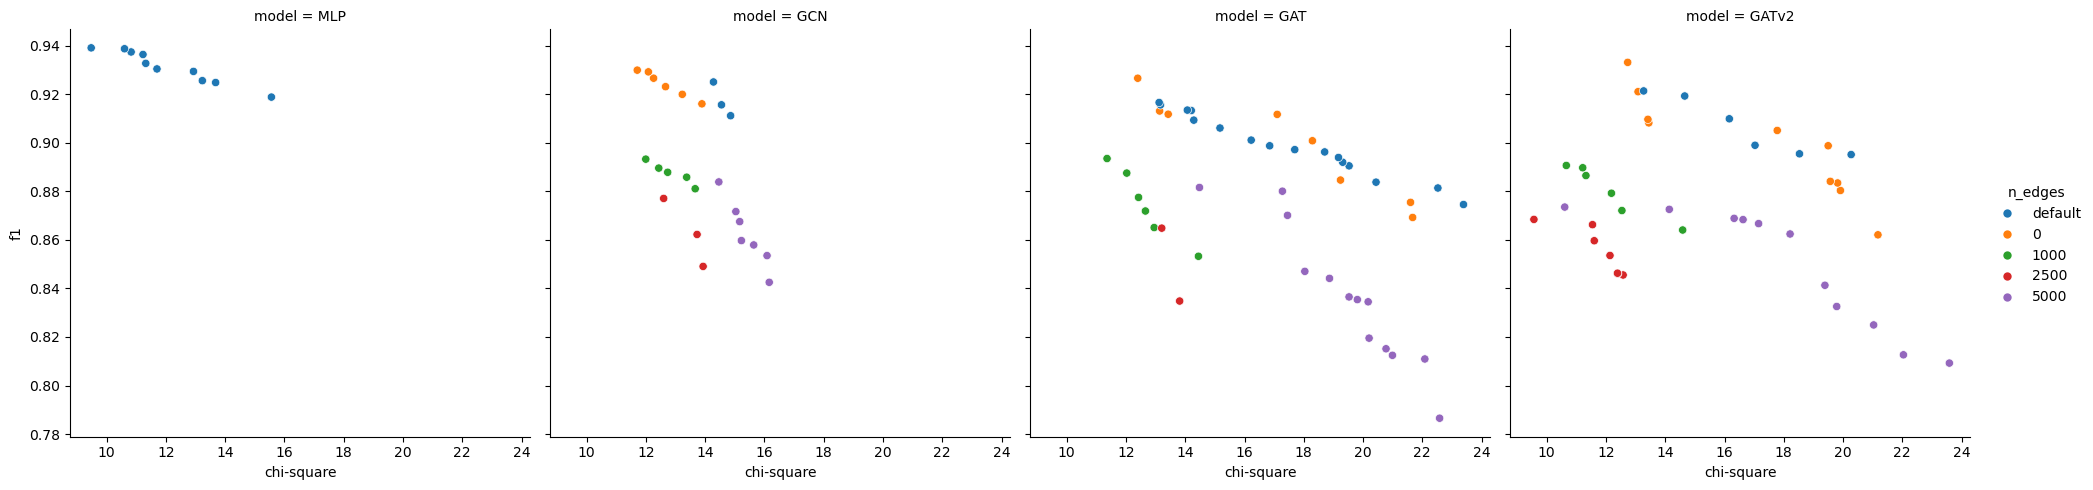

In [168]:
sns.relplot(data=trials, y="f1", x="chi-square", hue="n_edges", col="model")

## Best trials

In [48]:
import seaborn as sns
import pandas as pd

df_best = pd.DataFrame(df_best)
df_best["n_edges"] = df_best["n_edges"].fillna(0)
df_best["model"] = pd.Categorical(df_best["model"], categories=["MLP","GCN","GAT","GATv2"])
df_best["n_edges"] = pd.Categorical(df_best["n_edges"], categories=[0, "default", 1000, 2500, 5000])
df_best.sort_values(["n_edges","model"], inplace=True)
df_best

,model,n_edges,cls_type,finetuned_by,f1,chi-square
0,MLP,0,MLP,f1,0.939148,9.478961
1,MLP,0,MLP,chi_squared,0.918855,15.560009
33,GCN,0,GCN,chi_squared,0.910364,14.217483
32,GCN,0,GCN,f1,0.928128,10.578956
3,GCN,0,MLP,chi_squared,0.914169,13.264737
...,...,...,...,...,...,...
20,GAT,5000,MLP,f1,0.880511,16.006074
30,GATv2,5000,MLP,f1,0.876293,16.076584
60,GATv2,5000,GATv2,f1,0.892963,15.728651
31,GATv2,5000,MLP,chi_squared,0.796967,25.100060


In [50]:
df = df_best[df_best["finetuned_by"]=="chi_squared"]
df

,model,n_edges,cls_type,finetuned_by,f1,chi-square
1,MLP,0,MLP,chi_squared,0.918855,15.560009
33,GCN,0,GCN,chi_squared,0.910364,14.217483
3,GCN,0,MLP,chi_squared,0.914169,13.264737
43,GAT,0,GAT,chi_squared,0.829206,21.963605
13,GAT,0,MLP,chi_squared,0.873443,21.998303
53,GATv2,0,GATv2,chi_squared,0.881696,20.700504
23,GATv2,0,MLP,chi_squared,0.905973,17.339582
35,GCN,default,GCN,chi_squared,0.906538,15.231066
5,GCN,default,MLP,chi_squared,0.915949,15.808432
45,GAT,default,GAT,chi_squared,0.850031,24.647466


### N. edges

In [51]:
# Of all f1 top trials,for every model and n of edges select the one with highest chi-square

idx = (
    df.groupby(["model", "n_edges"])["chi-square"].transform("max")
    == df["chi-square"]
)
f1_edges = df[idx]
f1_edges.sort_values("n_edges", inplace=True)
f1_edges

/tmp/ipykernel_6711/407777393.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["model", "n_edges"])["chi-square"].transform("max")
/tmp/ipykernel_6711/407777393.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1_edges.sort_values("n_edges", inplace=True)


,model,n_edges,cls_type,finetuned_by,f1,chi-square
1,MLP,0,MLP,chi_squared,0.918855,15.560009
33,GCN,0,GCN,chi_squared,0.910364,14.217483
13,GAT,0,MLP,chi_squared,0.873443,21.998303
53,GATv2,0,GATv2,chi_squared,0.881696,20.700504
5,GCN,default,MLP,chi_squared,0.915949,15.808432
45,GAT,default,GAT,chi_squared,0.850031,24.647466
55,GATv2,default,GATv2,chi_squared,0.841609,24.317336
7,GCN,1000,MLP,chi_squared,0.873237,13.380797
47,GAT,1000,GAT,chi_squared,0.830262,16.466470
57,GATv2,1000,GATv2,chi_squared,0.823656,17.062248


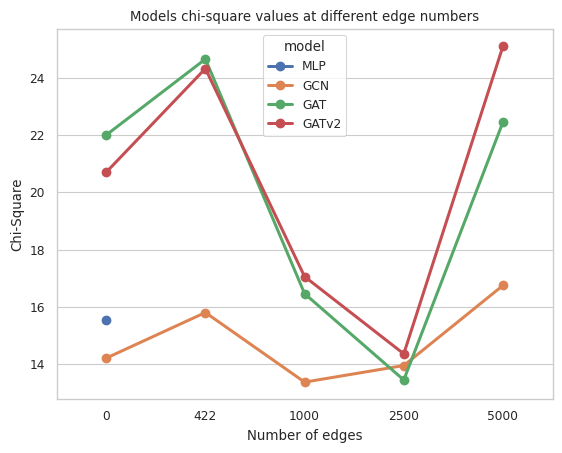

In [71]:
# sns.set_style("ticks")
# sns.set_context("paper")
sns.set_theme(context='paper', style='whitegrid', palette=sns.color_palette())
sns.pointplot(data=f1_edges, x="n_edges", y="chi-square", hue="model")
plt.title("Models chi-square values at different edge numbers")
plt.xlabel("Number of edges")
plt.ylabel("Chi-Square")
plt.xticks(ticks=["0","default","1000","2500","5000"],labels=["0", "422", "1000", "2500", "5000"])
plt.show()

### MLP vs GNN

In [53]:
# Of all f1 top trials,for every model and cls layer type, select the one with highest chi-square

f1_cls_layer = pd.concat([df[df["cls_type"]=="MLP"].sort_values("chi-square", ascending=False).drop_duplicates(["model"]),
df[df["cls_type"]!="MLP"].sort_values("chi-square", ascending=False).drop_duplicates(["model"])])
f1_cls_layer

,model,n_edges,cls_type,finetuned_by,f1,chi-square
31,GATv2,5000,MLP,chi_squared,0.796967,25.100060
13,GAT,0,MLP,chi_squared,0.873443,21.998303
5,GCN,default,MLP,chi_squared,0.915949,15.808432
1,MLP,0,MLP,chi_squared,0.918855,15.560009
45,GAT,default,GAT,chi_squared,0.850031,24.647466
55,GATv2,default,GATv2,chi_squared,0.841609,24.317336
41,GCN,5000,GCN,chi_squared,0.868900,16.753430


In [55]:
f1_cls_layer["cls_layer"] = f1_cls_layer.apply(lambda row: row.cls_type if row.cls_type =="MLP" else "GNN", axis=1)
f1_cls_layer

,model,n_edges,cls_type,finetuned_by,f1,chi-square,cls_layer
31,GATv2,5000,MLP,chi_squared,0.796967,25.100060,MLP
13,GAT,0,MLP,chi_squared,0.873443,21.998303,MLP
5,GCN,default,MLP,chi_squared,0.915949,15.808432,MLP
1,MLP,0,MLP,chi_squared,0.918855,15.560009,MLP
45,GAT,default,GAT,chi_squared,0.850031,24.647466,GNN
55,GATv2,default,GATv2,chi_squared,0.841609,24.317336,GNN
41,GCN,5000,GCN,chi_squared,0.868900,16.753430,GNN


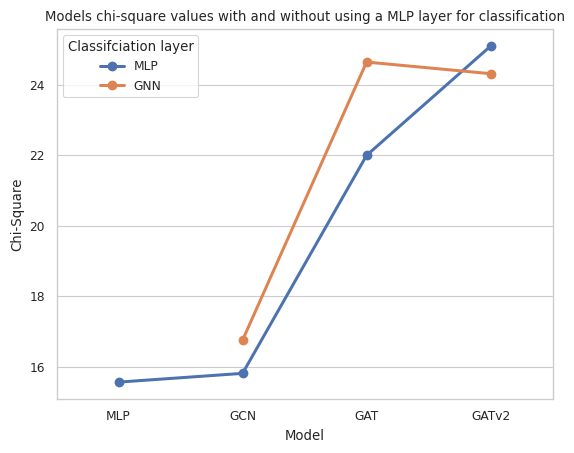

In [69]:
f1_cls_layer.sort_values("model", inplace=True)
sns.pointplot(data=f1_cls_layer, x="model", y="chi-square", hue="cls_layer")

plt.title("Models chi-square values with and without using a MLP layer for classification")
plt.xlabel("Model")
plt.ylabel("Chi-Square")
plt.legend(title="Classifciation layer")
plt.show()

### Best models

In [115]:
df_best.sort_values("f1", ascending=False).drop_duplicates(["model"])

,model,n_edges,cls_type,finetuned_by,f1,chi-square
0,MLP,0,MLP,f1,0.939148,9.478961
2,GCN,0,MLP,f1,0.936709,11.913331
22,GATv2,0,MLP,f1,0.935239,9.949413
12,GAT,0,MLP,f1,0.927001,11.084024


In [119]:
df_best.sort_values("chi-square", ascending=False).drop_duplicates(["model"])

,model,n_edges,cls_type,finetuned_by,f1,chi-square
31,GATv2,5000,MLP,chi_squared,0.796967,25.100060
45,GAT,default,GAT,chi_squared,0.850031,24.647466
41,GCN,5000,GCN,chi_squared,0.868900,16.753430
1,MLP,0,MLP,chi_squared,0.918855,15.560009


## Test results

## Predict survival

In [120]:
# surv data
import numpy as np

surv_data = pd.read_csv("../data/gt_data.csv")
data_y = surv_data[["Status", "Survival_in_days"]].to_records(index=False)

surv_struct = np.array(list(zip(surv_data["Status"].to_list(), surv_data["Survival_in_days"].to_list())), dtype=[("Status", "?"), ("Survival_in_days", "<f8")])

# masks
def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))

train_mask = get_bool_mask(surv_data, pd.read_csv("../data/train_pam50_stratified.csv")["Sample_ID"])
test_mask = get_bool_mask(surv_data, pd.read_csv("../data/test_pam50_stratified.csv")["Sample_ID"])

train_max = surv_data[train_mask]["Survival_in_days"].max()

In [123]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw


def combine_results(path, ids, exp_type="test"):

    metrics = None
    for id in ids:
        temp = pd.read_csv(os.path.join(path, id, exp_type, "metrics.csv"))
        

        data_x = pd.read_csv(
            os.path.join(path, id, exp_type, "latent_data.csv"), header=None
        )

        estimator = CoxPHSurvivalAnalysis()
        estimator.fit(data_x[train_mask], data_y[train_mask])
        estimate = estimator.predict(data_x[test_mask])
        c_index, _, _, _, _ = concordance_index_ipcw(
            surv_struct[train_mask], surv_struct[test_mask], estimate, tau=train_max
        )

        temp["c_index"] = c_index
        temp["model"] = id

        if metrics is None:
            metrics = temp
        else:
            metrics = pd.concat([metrics, temp], ignore_index=True)

    return metrics


path_results = f"../results"
ids = [id for id in os.listdir(path_results) if "study" not in id]
all_res = combine_results(path_results, ids)
all_res.to_csv("../cls_test_results.csv")
all_res

,acc,f1,chisqr,p_value,c_index,model
0,0.891089,0.883274,12.539947,0.005745,0.616325,GCN_0
1,0.851485,0.836366,22.476254,0.000052,0.473071,GCN_5000
2,0.811881,0.771435,11.569131,0.009015,0.564670,GAT_default
3,0.831683,0.820810,19.595607,0.000206,0.550020,GATv2_5000
4,0.910891,0.884694,13.559390,0.003571,0.583244,MLP_f1
5,0.871287,0.880599,18.636564,0.000325,0.466365,GAT_0
6,0.940594,0.937709,11.655922,0.008660,0.696184,MLP
7,0.851485,0.814628,23.548429,0.000031,0.466252,GATv2_0


In [110]:
data_x = pd.read_csv(
    os.path.join("../results", "0403224405", "test", "latent_data.csv"), header=None
)



0.5646702513458041
